In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
plt.style.use("ggplot")

In [2]:
# Read in orders data
df = pd.read_csv("4_columns_order_data.csv")
df.head()

,order_date,customer_id,revenue,quantity
0,2020-05-11 21:27:00,3395,12.75,1.0
1,2020-05-11 21:27:00,3395,4.99,1.0
2,2020-04-23 22:51:11.998000,21313,21.25,1.0
3,2020-04-06 10:45:38.002000,9844,29.75,1.0
4,2020-04-06 10:45:38.002000,9844,9.99,1.0


In [3]:
# Check data types
df.dtypes

order_date      object
customer_id      int64
revenue        float64
quantity       float64
dtype: object

In [4]:
# Customer_id should be in int, and order_date should be in date format. Let's convert them
df.order_date = pd.to_datetime(pd.to_datetime(df.order_date).dt.date)
df.customer_id = df.customer_id.astype("int")
df.head()

,order_date,customer_id,revenue,quantity
0,2020-05-11,3395,12.75,1.0
1,2020-05-11,3395,4.99,1.0
2,2020-04-23,21313,21.25,1.0
3,2020-04-06,9844,29.75,1.0
4,2020-04-06,9844,9.99,1.0


In [5]:
# Check data types again
df.dtypes

order_date     datetime64[ns]
customer_id             int64
revenue               float64
quantity              float64
dtype: object

In [6]:
# Check for null values
df.isna().sum()

order_date      0
customer_id     0
revenue        75
quantity       83
dtype: int64

In [7]:
# Drop rows with missing values
df = df.dropna(subset=["revenue", "quantity"])

# Now check again to see if the nulls are removed
df.isna().sum()

order_date     0
customer_id    0
revenue        0
quantity       0
dtype: int64

In [8]:
# Check for -ve values if any
df[(df.quantity<0) | (df.revenue<0)]

,order_date,customer_id,revenue,quantity


In [9]:
# Calculate the summary stats
df.describe()

,customer_id,revenue,quantity
count,76445.000000,76445.000000,76445.000000
mean,10540.472549,12.284927,1.078148
std,9147.664410,22.926256,0.482398
min,1.000000,0.000000,1.000000
25%,2440.000000,4.990000,1.000000
50%,7848.000000,9.990000,1.000000
75%,17331.000000,12.990000,1.000000
max,32533.000000,1303.650000,19.000000


### RFM Analysis
Here, you are going to perform following opertaions:

**For Recency, Calculate the number of days between present date and date of last purchase each customer.**

**For Frequency, Calculate the number of orders for each customer.**

**For Monetary, Calculate sum of purchase price for each customer.**

In [10]:
# Calculate rfm aggregated by customer_id
rfm_df = df.groupby("customer_id").agg({"order_date": lambda date: (datetime.datetime(2021,10,13) - date.max()).days,
                                        "quantity": lambda quan: len(quan),
                                        "revenue": lambda price: price.sum()})

# Rename columns
rfm_df.columns = ["recency", "frequency", "monetary"]
rfm_df.head(10)

,recency,frequency,monetary
customer_id,,,
1,303,135.0,1141.62
2,348,80.0,840.23
3,319,48.0,416.32
4,374,47.0,296.43
5,317,46.0,349.08
6,301,43.0,408.94
7,404,42.0,722.90
8,666,40.0,493.85
9,303,39.0,246.77


In [11]:
# Summary stats of recency
rfm_df.recency.describe().to_frame(name="recency_stats")

,recency_stats
count,32532.000000
mean,485.655693
std,143.511542
min,280.000000
25%,369.000000
50%,472.000000
75%,558.000000
max,1016.000000


In [12]:
# Summary stats of frequency
rfm_df.frequency.describe().to_frame(name="frequency_stats")

,frequency_stats
count,32532.000000
mean,2.349840
std,2.293807
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,135.000000


In [13]:
# Summary stats of revenue
rfm_df.monetary.describe().to_frame(name="monetary_stats")

,monetary_stats
count,32532.000000
mean,28.867615
std,50.177717
min,0.000000
25%,12.600000
50%,20.620000
75%,31.240000
max,2666.230000


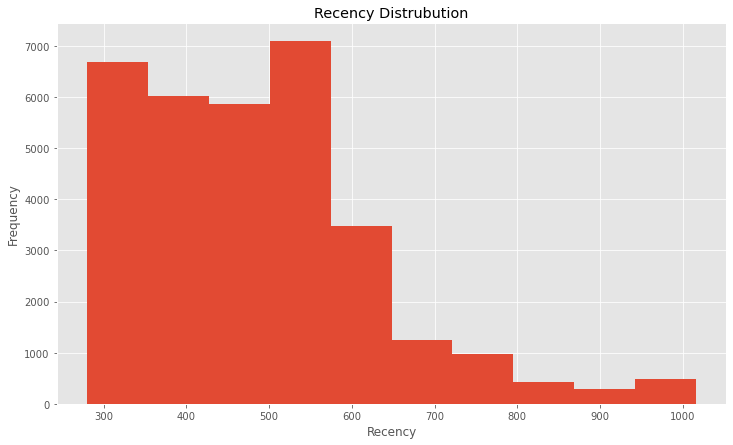

In [14]:
# Plot distribution of recency
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12,7))
rfm_df.recency.plot.hist(title="Recency Distrubution", ax=ax)
ax.set_xlabel("Recency")
plt.show()

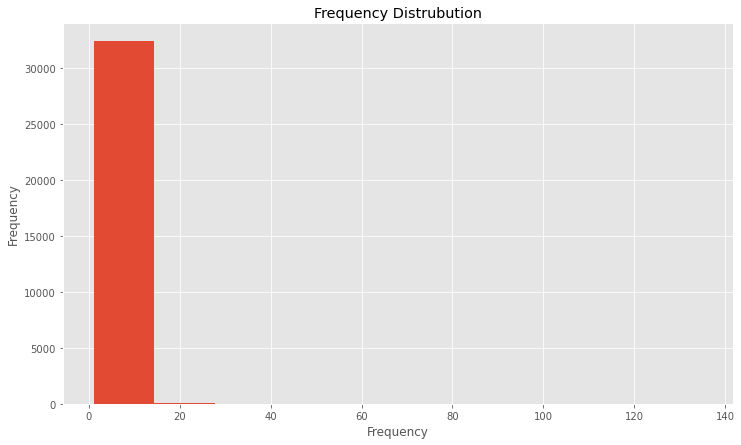

In [15]:
# Plot distribution of frequencyall
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12,7))
rfm_df.frequency.plot.hist(title="Frequency Distrubution", ax=ax)
ax.set_xlabel("Frequency")
plt.show()

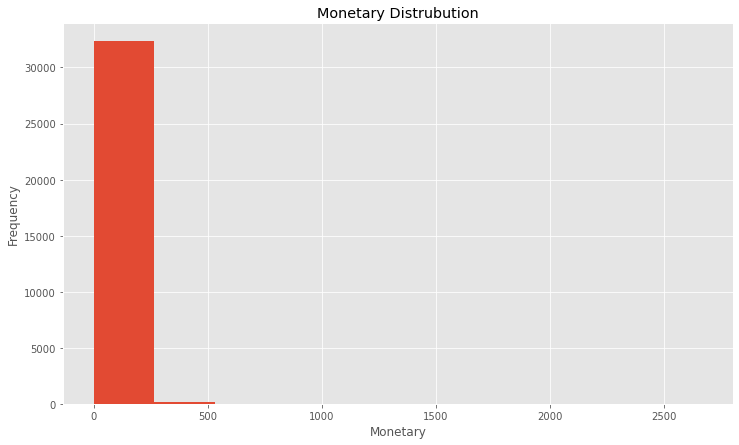

In [16]:
# Plot distribution of monetary
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12,7))
rfm_df.monetary.plot.hist(title="Monetary Distrubution", ax=ax)
ax.set_xlabel("Monetary")
plt.show()

#### Variable standarization

In [17]:
# Variables standarization
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(rfm_df)

# Turn the scaled data back into a dataframe
scaled_df = pd.DataFrame(data = scaled_arr, 
                                index = rfm_df.index, 
                                columns = rfm_df.columns) 
scaled_df.head(10)

,recency,frequency,monetary
customer_id,,,
1,-1.272779,57.830589,22.176567
2,-0.959211,33.852613,16.170023
3,-1.161288,19.901790,7.721721
4,-0.778038,19.465827,5.332377
5,-1.175225,19.029864,6.381664
6,-1.286716,17.721974,7.574642
7,-0.568992,17.286011,13.831699
8,1.256673,16.414085,9.266853
9,-1.272779,15.978121,4.342679


#### Finding the value of K using *elbow* method

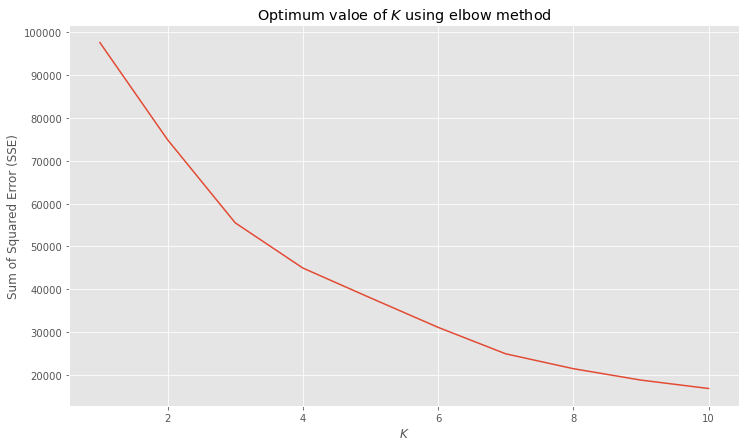

In [18]:
# To store sum of squared errors
sse = []
for n in range(1, 11):
    model = KMeans(n_clusters=n, random_state=3)
    model.fit(scaled_df.values)
    sse.append(model.inertia_)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,7))
ax.plot(range(1, 11), sse)
ax.set_xlabel("$K$")
ax.set_ylabel("Sum of Squared Error (SSE)")
ax.set_title("Optimum valoe of $K$ using elbow method")
plt.show()

#### We will use k=3 for the prediction

### Biuld the clustering algorithm

In [19]:
# Initialize the model
kmeans = KMeans(n_clusters = 3, random_state=1)

# Compute k-means clustering on scaled data
kmeans.fit(scaled_df)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_ 

In [20]:
# Insert the cluster columns into the main data
rfm_df["cluster"] = cluster_labels

##### Let’s do a bit of summary of the clusters we have just found out from the algorithm to understand the behavior of each subgroup we have just found out.

In [21]:
# Final summarization
summary = rfm_df.groupby(["cluster"]).agg({
    "recency":"mean",
    "frequency":"mean",
    "monetary":["mean", "count"]
    })
summary

recency frequency    monetary       
               mean      mean        mean  count
cluster                                         
0        620.911380  1.771638   21.338079  13067
1        393.476118  2.318249   24.777078  18319
2        416.939791  9.447644  180.109311   1146

#### Takeaway: From the table above, Cluster 2 is our most loyal customer.  They were at our websites 417 days ago and one agerage they visited our websites 9.45 times, while customers in Cluster 1 visited our websites only 2.31 times. And most importantly, Cluster 2 customers on average, have spent over 180 pounds.